In [30]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import interp1d
from diffractio.scalar_masks_X import Scalar_mask_X
%matplotlib ipympl


In [31]:
def get_pixel_coords(
    rays_x, rays_y, shape, pixel_size
):

    transform = np.eye(2)

    y_transformed, x_transformed = (np.array((rays_y, rays_x)).T @ transform).T

    sy, sx = shape
    pixel_coords_x = (x_transformed / pixel_size) + (sx // 2)
    pixel_coords_y = (y_transformed / pixel_size) + (sy // 2)

    return (pixel_coords_x, pixel_coords_y)

def interp_coordinates_from_optical_path_length(opl_0, opl_1, z_0, z_1, x_0, x_1, opl_value):
    N = len(opl_0)
    opl = np.vstack([opl_0, opl_1]).T
    z = np.vstack([z_0, z_1]).T
    x = np.vstack([x_0, x_1]).T

    z_given_opl = np.empty(N)
    x_given_z = np.empty(N)

    fn_vectorized = np.vectorize(interp1d,
                                        signature='(n),(n)->()')
    # Generate array of interpolation functions for z from opl
    interp_fn_array_z_from_opl = fn_vectorized(opl, z)

    # Generate array of interpolation functions for x from z
    interp_fn_array_x_from_z = fn_vectorized(z, x)

    # Initialize arrays for results
    z_given_opl = np.empty(N)
    x_given_z = np.empty(N)

    # Evaluate the interpolated values
    for i in range(N):
        z_given_opl[i] = interp_fn_array_z_from_opl[i](opl_value)
        x_given_z[i] = interp_fn_array_x_from_z[i](z_given_opl[i])
        
    return z_given_opl, x_given_z
    

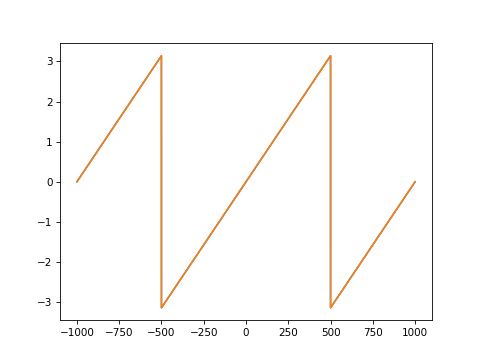

In [32]:
wavelength = 1

width = 2000
d = 1000
T = width / d
x = np.linspace(-1000,1000,10000)
z = np.linspace(2 * 1e3, 2 * 1e3, 128)

t_blazed_x = Scalar_mask_X(x, wavelength)
t_blazed_x.blazed_grating(x0=0, period=1000, phase_max=2 * np.pi)
phase_grating = np.exp(1j * (x * T * 2 * np.pi) / width)

phase_grating_derivative = (T * 2 * np.pi) / width

plt.figure()
plt.plot(x, np.angle(t_blazed_x.u))
plt.plot(x, np.angle(phase_grating))

In [33]:
def calculate_mdx_mdy(x1, y1, z1, u1, v1, z2):
    
    # Calculate derivatives 
    d_x1 = d_y1 = z1 / 1000
    
    # Direction vectors of derivative ray
    d_vx_pp1 = u1 - (x1 + d_x1)
    d_vy_pp1 = v1 - (y1 + d_y1)
    vz_pp1 = 0.0 - z1
    d_v_mag = np.sqrt(d_vx_pp1**2 + d_vy_pp1**2 + vz_pp1**2)
    
    # And direction cosines
    d_M1_p = d_vy_pp1 / d_v_mag 
    d_L1_p = d_vx_pp1 / d_v_mag

    d_x2 = z2 * d_L1_p
    d_y2 = z2 * d_M1_p
    
    # To obtain derivative in magnification - which I don't know at all if it is correct. 
    mdx = d_x2 / (x1 + d_x1)
    mdy = d_y2 / (y1 + d_y1)
    
    return mdx, mdy

def calculate_direction_cosines(x0, y0, z0, x1, y1, z1):
    # Calculate the principal ray vector from ray coordinate on object to centre of lens
    vx = x1 - x0
    vy = y1 - y0
    vz = z1 - z0
    v_mag = np.sqrt(vx**2 + vy**2 + vz**2)
    
    # And it's direction cosines
    M = vy / v_mag 
    L = vx / v_mag
    N = vz / v_mag
    
    return L, M, N
    
def propagate(x, y, z, L, M, N, d, opl):
    dx = (L / N) * d
    dy = (M / N) * d
    dz = (N / N) * d
    x1 = x + dx
    y1 = y + dy
    z1 = z + dz
    
    opl_out = opl + np.sqrt(dx ** 2 + dy ** 2 + dz ** 2)
    
    return x1, y1, z1, opl_out

def diffraction_grating(x, y, z, L, M, opl, wl, T = 200, width = 10):
    random_order = np.random.choice([-1, 1], len(x))
    # angle = np.arcsin(random_order * wl * T)
    L1 = L
    M1 = M + (random_order * wl * T)
    N1 = np.sqrt(1 - L1 ** 2 - M1 ** 2)
    opl1 = opl + (random_order * wl * T * y)
    
    return x, y, z, L1, M1, N1, opl1

def diffraction_grating_sinusoidal(x, y, z, L, M, N, opl, wl, Order = 1, T = 1 / 200, width = 10):
    random_order = np.random.choice([1, 1], len(x))

    L1 = L
    M1 = M - random_order * (np.sin(2 * np.pi * 200 * y) * (2 * np.pi * 200))
    N1 = np.sqrt(1 - L1 ** 2 - M1 ** 2)
    opl1 = opl + random_order * (np.cos(2 * np.pi * 200 * y))
    
    return x, y, z, L1, M1, N1, opl1

def rotation_matrix(x, y, alpha):
    return x * np.cos(alpha) - y * np.sin(alpha), x * np.sin(alpha) + y * np.cos(alpha)
    


In [34]:
def fourier_lens(x1, y1, z1, L1, M1, N1, z2, m_p, opl_in):
    
    # Obtain the location where the ray hits the first principal plane
    u1 = - (L1 / N1) * z1 + x1
    v1 = - (M1 / N1) * z1 + y1
    
    # If magnification is less than or equal to 1.0 - run this block
    if np.abs(m_p) <= 1.0:
        if np.abs(m_p) <= 1e-10:
            z1_old = z1
            z1 = -1e10
            m_p = z2 / z1
            
            principal_plane_x = u1
            principal_plane_y = v1
            L1_p, M1_p, N1_p = L1, M1, N1
            
            mdx, mdy = calculate_mdx_mdy(x1, y1, z1_old, principal_plane_x, principal_plane_y, z2)
        else:
            principal_plane_x = 0.0
            principal_plane_y = 0.0
            L1_p, M1_p, N1_p = calculate_direction_cosines(x1, y1, z1, principal_plane_x, principal_plane_y, 0.0)
            
            mdx, mdy = calculate_mdx_mdy(x1, y1, z1, principal_plane_x, principal_plane_y, z2)
        
        # Obtain coordinates in image plane relative to principal ray location
        x2 = z2 * L1_p
        y2 = z2 * M1_p
    
        rp = np.sqrt(x2 ** 2 + y2 **2 + z2 ** 2)
        
        # Obtain direction cosines of principal ray from second principal plane to image point
        L2_p = (x2 - principal_plane_x)  / rp
        M2_p = (y2 - principal_plane_y) / rp
        N2_p = np.sqrt(1 - L2_p ** 2 - M2_p ** 2)
        
    # For the case when m is greater than 1.0
    elif np.abs(m_p) > 1.0:
        if np.abs(m_p) >= 1e10:
            z2_old = z2
            z2 = 1e10
            m_p = z2 / z1
            principal_plane_x = u1
            principal_plane_y = v1
            mdx, mdy = calculate_mdx_mdy(x1, y1, z1, principal_plane_x, principal_plane_y, z2)
            L1_p, M1_p, N1_p = calculate_direction_cosines(x1, y1, z1, 0.0, 0.0, 0.0)
        else:
            z2_old = z2
            principal_plane_x = 0.0
            principal_plane_y = 0.0
            L1_p, M1_p, N1_p = calculate_direction_cosines(x1, y1, z1, principal_plane_x, principal_plane_y, 0.0)
            mdx, mdy = calculate_mdx_mdy(x1, y1, z1, principal_plane_x, principal_plane_y, z2)
            
        L2_p = x1 / z1
        M2_p = y1 / z1
        N2_p = np.sqrt(1 - L2_p ** 2 - M2_p ** 2)
        
        z2 = z2_old
        x2 = (L2_p / N2_p) * z2 + principal_plane_x
        y2 = (M2_p / N2_p) * z2 + principal_plane_y

    Cx = (mdx * L2_p) - L1_p
    Cy = (mdy * M2_p) - M1_p

    L2 = (L1 + Cx) / mdx
    M2 = (M1 + Cy) / mdy
    N2 = (1 - (L2 ** 2) - (M2 ** 2)) ** (1/2)

    #Analytic direction cosines:
    u2 = - (L2 / N2) * z2 + x2
    v2 = - (M2 / N2) * z2 + y2
    
    opl1 = np.sqrt((u1 - x1) ** 2 + (v1 - y1) **2 + (z1 ** 2)) + np.sqrt((x2 - u2) ** 2 + (y2 - v2) **2 + (z2 ** 2)) 
    opl0 = np.sqrt((u1 - principal_plane_x) ** 2 + (v1 - principal_plane_y) **2 + (z1 ** 2)) + np.sqrt((x2 - principal_plane_x) ** 2 + (y2 - principal_plane_y) **2 + (z2 ** 2)) 
    
    opl_ray = opl_in + (opl0 - opl1)
    return x2, y2, u1, v1, u2, v2, L2, M2, N2, opl_ray
    

In [35]:
def perfect_lens(x1, y1, z1, L1, M1, N1, z2, m_p):
    
    # Obtain the location where the ray hits the first principal plane
    u1 = - (L1 / N1) * z1 + x1
    v1 = - (M1 / N1) * z1 + y1
    
    mdx = mdy = m_p
    
    # If magnification is less than or equal to 1.0 - run this block
    if np.abs(m_p) <= 1.0:
        if np.abs(m_p) <= 1e-10:
            z1 = -1e10
            m_p = z2 / z1
            
            principal_plane_x = u1
            principal_plane_y = v1
            L1_p, M1_p, N1_p = L1, M1, N1
        else:
            principal_plane_x = 0.0
            principal_plane_y = 0.0
            L1_p, M1_p, N1_p = calculate_direction_cosines(x1, y1, z1, principal_plane_x, principal_plane_y, 0.0)
            
        # Obtain coordinates in image plane relative to principal ray location
        x2 = z2 * L1_p / N1_p
        y2 = z2 * M1_p / N1_p
    
        rp = np.sqrt(x2 ** 2 + y2 **2 + z2 ** 2)
        
        # Obtain direction cosines of principal ray from second principal plane to image point
        L2_p = (x2 - principal_plane_x) / rp
        M2_p = (y2 - principal_plane_y) / rp
        N2_p = np.sqrt(1 - L2_p ** 2 - M2_p ** 2)
        
    # For the case when m is greater than 1.0
    elif np.abs(m_p) > 1.0:
        if np.abs(m_p) >= 1e10:
            z2_old = z2
            z2 = 1e10
            m_p = z2 / z1
            principal_plane_x = u1
            principal_plane_y = v1
            mdx, mdy = calculate_mdx_mdy(x1, y1, z1, principal_plane_x, principal_plane_y, z2)
            L1_p, M1_p, N1_p = calculate_direction_cosines(x1, y1, z1, 0.0, 0.0, 0.0)
        else:
            z2_old = z2
            principal_plane_x = 0.0
            principal_plane_y = 0.0
            L1_p, M1_p, N1_p = calculate_direction_cosines(x1, y1, z1, principal_plane_x, principal_plane_y, 0.0)
            
        a = x1 / z1
        b = y1 / z1

        z2 = z2_old
        N2_p = np.sqrt(1 + a ** 2 + b ** 2)
        L2_p = a * N2_p
        M2_p = b * N2_p
        x2 = (L2_p / N2_p) * z2 + principal_plane_x
        y2 = (M2_p / N2_p) * z2 + principal_plane_y
        
    Cx = (mdx * L2_p) - L1_p
    Cy = (mdy * M2_p) - M1_p

    L2 = (L1 + Cx) / mdx
    M2 = (M1 + Cy) / mdy
    N2 = (1 - (L2 ** 2) - (M2 ** 2)) ** (1/2)

    #Analytic direction cosines:
    u2 = - (L2 / N2) * z2 + x2
    v2 = - (M2 / N2) * z2 + y2
    
    opl1 = np.sqrt((u1 - x1) ** 2 + (v1 - y1) **2 + (z1 ** 2)) + np.sqrt((x2 - u2) ** 2 + (y2 - v1) **2 + (z2 ** 2)) 
    opl0 = np.sqrt((x1 - principal_plane_x) ** 2 + (y1 - principal_plane_y) **2 + (z1 ** 2)) + np.sqrt((x2 - principal_plane_x) ** 2 + (y2 - principal_plane_y) **2 + (z2 ** 2)) 
    
    opl_ray = (opl0 - opl1)
    return x2, y2, u1, v1, u2, v2, L2, M2, N2, opl_ray
    

In [36]:
def perfect_lens_jeffrey(u1, v1, L1, M1, N1, f, m_p, opl_in):
    NA1 = 0.1
    NA2 = 0.1
    
    # If magnification is less than or equal to 1.0 - run this block
    if np.abs(m_p) <= 1e-10:
        z1 = -1e10
        z2 = f
    elif np.abs(m_p) > 1e10:
        z1 = -f
        z2 = 1e10
    else:
        z1 = f * (1/m_p - 1)
        z2 = f * (1 - m_p)
    
    if np.abs(z1) >= 1e10:
        z1 = 1e10 * (z1 / np.abs(z1))
        NA1 = 0.0  #collimated input
        
    if np.abs(z2) >= 1e10:
        z2 = 1e10 * (z2 / np.abs(z2))
        NA2 = 0.0  #collimated input
        
    m_p = z2 / z1
    
    # Ray object point coordinates (x1, y1) on front conjugate plane
    if (NA1 == 0.0):
        x1 = (L1 / N1) * z1
        y1 = (M1 / N1) * z1
        r1_mag = np.sqrt((x1 - u1) ** 2 + (y1 - v1) ** 2 + z1 ** 2)
        
        L1_est = -(x1 - u1) / r1_mag
        M1_est = -(y1 - v1) / r1_mag
    else:
        
        x1 = (L1 / N1) * z1 + u1
        y1 = (M1 / N1) * z1 + v1
        r1_mag = np.sqrt((x1 - u1) ** 2 + (y1 - v1) ** 2 + z1 ** 2)
        
    if (NA1 == 0.0):
        L1_p = L1
        M1_p = M1
        N1_p = N1
        p1_mag = np.sqrt(x1 ** 2 + y1 ** 2 + z1 ** 2)
    else:
        p1_mag = np.sqrt(x1 ** 2 + y1 ** 2 + z1 ** 2)
        
        # Obtain direction cosines of principal ray from second principal plane to image point
        L1_p = (x1 / p1_mag) * z1 / np.abs(z1)
        M1_p = (y1 / p1_mag) * z1 / np.abs(z1)
        N1_p = np.sqrt(1 - L1_p ** 2 - M1_p ** 2)
        
    if np.abs(m_p) <= 1.0:
        x2 = z2 * (L1_p / N1_p)
        y2 = z2 * (M1_p / N1_p)
        
        p2_mag = np.sqrt(x2 ** 2 + y2 ** 2 + z2 ** 2)
        L2_p = (x2 / p2_mag) * (z2 / np.abs(z2))
        M2_p = (y2 / p2_mag) * (z2 / np.abs(z2))
        N2_p = np.sqrt(1 - L2_p ** 2 - M2_p ** 2)
    else:
        a = x1 / z1
        b = y1 / z1
        N2_p = 1 / np.sqrt(1 + a ** 2 + b ** 2)
        L2_p = a * N2_p
        M2_p = b * N2_p
        x2 = (L2_p / N2_p) * z2
        y2 = (M2_p / N2_p) * z2
        print('Y2 Perfect Lens = ', y2)
        p2_mag = np.sqrt(x2 ** 2 + y2 ** 2 + z2 ** 2)
        
    Cx = m_p * L2_p - L1_p
    Cy = m_p * M2_p - M1_p  
    print('Cy Perfect Lens = ', Cy)
    
    if (NA1 == 0.0):
        L2 = (L1_est + Cx) / m_p
        M2 = (M1_est + Cy) / m_p
        N2 = np.sqrt(1 - L2 ** 2 - M2 ** 2)
    else:
        L2 = (L1 + Cx) / m_p
        M2 = (M1 + Cy) / m_p
        
        print('M1 Perfect Lens = ', M1)
        print('m_p Perfect Lens = ', m_p)
        N2 = np.sqrt(1 - L2 ** 2 - M2 ** 2)
    
    mask = np.sqrt(u1 ** 2 + v1 ** 2) < 1e-7
    
    # Initialize the output arrays
    u2 = np.zeros_like(u1)
    v2 = np.zeros_like(v1)

    # Handle the case where the mask is true and NA2 = 0.0
    if NA2 == 0.0:
        a = -x1 / f
        b = -y1 / f
        N2_p = 1 / np.sqrt(1 + a ** 2 + b ** 2)
        L2_p = a * N2_p
        M2_p = b * N2_p

        L2[mask] = L2_p[mask]
        M2[mask] = M2_p[mask]
        N2[mask] = N2_p[mask]
        u2[mask] = 0.0
        v2[mask] = 0.0

    # For the case where the mask is false
    not_mask = ~mask
    u2[not_mask] = -(L2[not_mask] / N2[not_mask]) * z2 + x2[not_mask]
    v2[not_mask] = -(M2[not_mask] / N2[not_mask]) * z2 + y2[not_mask]

    if NA2 == 0:
        a = -x1 / f
        b = -y1 / f
        N2_p = 1 / np.sqrt(1 + a ** 2 + b ** 2)
        L2_p = a * N2_p
        M2_p = b * N2_p

        L2[not_mask] = L2_p[not_mask]
        M2[not_mask] = M2_p[not_mask]
        N2[not_mask] = N2_p[not_mask]

    r2_mag = np.sqrt((x2 - u2) ** 2 + (y2 - v2) ** 2 + z2 ** 2)
    opl1 = r1_mag + r2_mag
    opl0 = p1_mag + p2_mag
    opl = opl_in + (opl0 - opl1)

    return u2, v2, L2, M2, N2, opl


In [37]:
def fourier_lens_jeffrey(u1, v1, L1, M1, N1, f, m_p, opl_in):
    
    alpha = np.arctan2(v1, u1) + np.pi / 2
    
    u1, v1 = rotation_matrix(u1, v1, alpha)
    L1, M1 = rotation_matrix(L1, M1, alpha)
    
    NA1 = 0.1
    NA2 = 0.1
    
    # If magnification is less than or equal to 1.0 - run this block
    if np.abs(m_p) <= 1e-10:
        z1 = -1e10
        z2 = f
    elif np.abs(m_p) > 1e10:
        z1 = -f
        z2 = 1e10
    else:
        z1 = f * (1/m_p - 1)
        z2 = f * (1 - m_p)
    
    if np.abs(z1) >= 1e10:
        z1 = 1e10 * (z1 / np.abs(z1))
        NA1 = 0.0  #collimated input
        
    if np.abs(z2) >= 1e10:
        z2 = 1e10 * (z2 / np.abs(z2))
        NA2 = 0.0  #collimated input
        
    # Ray object point coordinates (x1, y1) on front conjugate plane
    if (NA1 == 0.0):
        x1 = (L1 / N1) * z1
        y1 = (M1 / N1) * z1
        
        dx1 = x1 + (z1 / 1000)
        dy1 = y1 + (z1 / 1000)
        
        r1_mag = np.sqrt((x1 - u1) ** 2 + (y1 - v1) ** 2 + z1 ** 2)
        
        L1_est = - (x1 - u1) / r1_mag
        M1_est = - (y1 - v1) / r1_mag
        
    else:
        x1 = (L1 / N1) * z1 + u1
        y1 = (M1 / N1) * z1 + v1
        r1_mag = np.sqrt((x1 - u1) ** 2 + (y1 - v1) ** 2 + z1 ** 2)
        
        dx1 = x1 + (z1 / 1000)
        dy1 = y1 + (z1 / 1000)
        
    if (NA1 == 0.0):
        L1_p = L1
        M1_p = M1
        
        dL1_p = L1
        dM1_p = M1
        
        p1_mag = np.sqrt(x1 ** 2 + y1 ** 2 + z1 ** 2)
        dp1_mag = np.sqrt(dx1 ** 2 + dy1 ** 2 + z1 ** 2)
    else:
        p1_mag = np.sqrt(x1 ** 2 + y1 ** 2 + z1 ** 2)
        dp1_mag = np.sqrt(dx1 ** 2 + dy1 ** 2 + z1 ** 2)
        
        # Obtain direction cosines of principal ray from second principal plane to image point
        L1_p = (x1 / p1_mag) * z1 / np.abs(z1)
        M1_p = (y1 / p1_mag) * z1 / np.abs(z1)
        
        dL1_p = (dx1 / dp1_mag) * z1 / np.abs(z1)
        dM1_p = (dy1 / dp1_mag) * z1 / np.abs(z1)
        
    if np.abs(m_p) <= 1.0:
        x2 = z2 * (L1_p)
        y2 = z2 * (M1_p)
        
        dx2 = z2 * dL1_p
        dy2 = z2 * dM1_p
        
        p2_mag = np.sqrt(x2 ** 2 + y2 ** 2 + z2 ** 2)
        L2_p = (x2 / p2_mag) * (z2 / np.abs(z2))
        M2_p = (y2 / p2_mag) * (z2 / np.abs(z2))
        N2_p = np.sqrt(1 - L2_p ** 2 - M2_p ** 2)
        
    else:
        L2_p = (x1 / z1) * (z2 / np.abs(z2))
        M2_p = (y1 / z1) * (z2 / np.abs(z2))
        N2_p = np.sqrt(1 - L2_p ** 2 - M2_p ** 2)
        
        dL2_p = (dx1 / z1) * (z2 / np.abs(z2))
        dM2_p = (dy1 / z1) * (z2 / np.abs(z2))
        dN2_p = np.sqrt(1 - dL2_p ** 2 - dM2_p ** 2)
        
        dx2 = (dL2_p / dN2_p) * z2
        dy2 = (dM2_p / dN2_p) * z2
        
        x2 = (L2_p / N2_p) * z2
        y2 = (M2_p / N2_p) * z2
        p2_mag = np.sqrt(x2 ** 2 + y2 ** 2 + z2 ** 2)
    
    mdx = dx2 / dx1
    mdy = dy2 / dy1
    
    Cx = mdx * L2_p - L1_p
    Cy = mdy * M2_p - M1_p  
    
    if (NA1 == 0.0):
        L2 = L1_est * 0.0
        M2 = (M1_est + Cy) / mdy
        N2 = np.sqrt(1 - L2 ** 2 - M2 ** 2)
    else:
        L2 = (L1 + Cx) / mdx
        M2 = (M1 + Cy) / mdy
        N2 = np.sqrt(1 - L2 ** 2 - M2 ** 2)
    
    # Calculate the mask for the condition
    mask = np.sqrt(u1 ** 2 + v1 ** 2) < 1e-7

    # Initialize the output arrays
    u2 = np.zeros_like(u1)
    v2 = np.zeros_like(v1)

    # Handle the case where the mask is true and NA2 = 0.0
    if NA2 == 0.0:
        a = -x1 / f
        b = -y1 / f
        N2_p = 1 / np.sqrt(1 + a ** 2 + b ** 2)
        L2_p = a * N2_p * (z2 / np.abs(z2))
        M2_p = b * N2_p * (z2 / np.abs(z2))

        L2[mask] = L2_p[mask]
        M2[mask] = M2_p[mask]
        N2[mask] = N2_p[mask]
        u2[mask] = 0.0
        v2[mask] = 0.0

    # Apply the rotation_matrix function
    L2[mask], M2[mask] = rotation_matrix(L2[mask], M2[mask], -alpha[mask])
    u2[mask], v2[mask] = rotation_matrix(u2[mask], v2[mask], -alpha[mask])

    # For the case where the mask is false
    not_mask = ~mask
    u2[not_mask] = -(L2[not_mask] / N2[not_mask]) * z2 + x2[not_mask]
    v2[not_mask] = -(M2[not_mask] / N2[not_mask]) * z2 + y2[not_mask]

    if NA2 == 0:
        a = -x1 / f
        b = -y1 / f
        N2_p = 1 / np.sqrt(1 + a ** 2 + b ** 2)
        L2_p = a * N2_p * (z2 / np.abs(z2))
        M2_p = b * N2_p * (z2 / np.abs(z2))

        L2[not_mask] = L2_p[not_mask]
        M2[not_mask] = M2_p[not_mask]
        N2[not_mask] = N2_p[not_mask]

    r2_mag = np.sqrt((x2 - u2) ** 2 + (y2 - v2) ** 2 + z2 ** 2)
    
    opl1 = r1_mag + r2_mag
    opl0 = p1_mag + p2_mag
    opl = opl_in + (opl0 - opl1)

    # Apply the rotation_matrix function again
    L2[not_mask], M2[not_mask] = rotation_matrix(L2[not_mask], M2[not_mask], -alpha[not_mask])
    u2[not_mask], v2[not_mask] = rotation_matrix(u2[not_mask], v2[not_mask], -alpha[not_mask])

    return u2, v2, L2, M2, N2, opl

Perfect Lens: Infinite Front Conjugate Case

In [38]:
lens_z = 0.0
thickness = 0.0
pp_1 = lens_z - thickness / 2.0
pp_2 = lens_z + thickness / 2.0

m_p = 1e11
f = 10

if np.abs(m_p) < 1e-10:
    z1 = f * (-1)  
    z2 = f * (1)
elif np.abs(m_p) > 1e10:
    z1 = f * (-1)  
    z2 = f * (1)
else:
    z1 = f * ((1 / m_p)  -1)
    z2 = f * (1 - m_p)

N = 10

# Define x and y coordinates of rat starting positions
x1 = np.linspace(-0.0, 0.0, N)
y1 = np.linspace(2, 2, N)
z1 = np.linspace(z1, z1, N)

angles = np.linspace(-1, -1, N)

L1 = np.zeros(N) # x direction cosine
M1 = np.sin(angles) # y direction cosine
N1 = np.sqrt(1 - L1 ** 2 - M1 ** 2) #z direction 

opl = np.linspace(0, 0, N)

Y2 Perfect Lens =  [-2.e+09 -2.e+09 -2.e+09 -2.e+09 -2.e+09 -2.e+09 -2.e+09 -2.e+09 -2.e+09
 -2.e+09]
Cy Perfect Lens =  [1.96116135e+08 1.96116135e+08 1.96116135e+08 1.96116135e+08
 1.96116135e+08 1.96116135e+08 1.96116135e+08 1.96116135e+08
 1.96116135e+08 1.96116135e+08]
M1 Perfect Lens =  [-0.84147098 -0.84147098 -0.84147098 -0.84147098 -0.84147098 -0.84147098
 -0.84147098 -0.84147098 -0.84147098 -0.84147098]
m_p Perfect Lens =  -1000000000.0


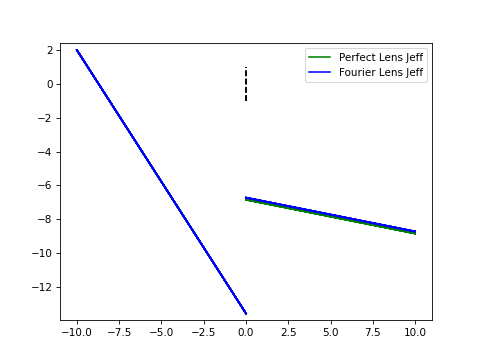

In [39]:

plt.figure()

# Obtain the location where the ray hits the first principal plane
u1 = - (L1 / N1) * z1 + x1
v1 = - (M1 / N1) * z1 + y1

opl_in = np.zeros(N)
opl_l = opl_in + np.sqrt(((M1 / N1) * z1) ** 2 + z1 ** 2)
u2, v2, L2, M2, N2, opl = perfect_lens_jeffrey(u1, v1, L1, M1, N1, f, m_p, opl_in)
x2, y2 = u2 + (L2 / N2) * z2, v2 + (M2 / N2) * z2

opl_r = opl_l + opl
opl_focal = opl_r + np.sqrt(((M2 / N2) * z2) ** 2 + z2 ** 2)


plt.vlines(pp_1, -1, 1, linestyle = '--', color = 'k')
plt.vlines(pp_2,  -1, 1, linestyle = '--', color = 'k')

pp_1s = np.linspace(pp_1, pp_1, N)
pp_2s = np.linspace(pp_2, pp_2, N)
z1s = np.linspace(z1, z1, N)
z2s = np.linspace(z2, z2, N)
fs = np.linspace(f, f, N)

plt.plot([z1 + pp_1s, pp_1s], [y1, v1], '-g')
plt.plot([], [], '-g', label = 'Perfect Lens Jeff')

plt.plot([pp_2s, z2s + pp_2s], [v2, y2], '-g')
plt.axis('equal')

opl_in = np.zeros(N)

# Obtain the location where the ray hits the first principal plane
u1 = - (L1 / N1) * z1 + x1
v1 = - (M1 / N1) * z1 + y1

opl_in = np.zeros(N)
opl_l = opl_in + np.sqrt(((M1 / N1) * z1) ** 2 + z1 ** 2)
opl_r = opl_l + opl
opl_focal = opl_r + np.sqrt(((M2 / N2) * z2) ** 2 + z2 ** 2)

u2, v2, L2, M2, N2, opl = fourier_lens_jeffrey(u1, v1, L1, M1, N1, f, m_p, opl_in)
x2, y2 = u2 + (L2 / N2) * z2, v2 + (M2 / N2) * z2

pp_1s = np.linspace(pp_1, pp_1, N)
pp_2s = np.linspace(pp_2, pp_2, N)
z1s = np.linspace(z1, z1, N)
z2s = np.linspace(z2, z2, N)
fs = np.linspace(f, f, N)

plt.plot([z1 + pp_1s, pp_1s], [y1, v1], '-b')
plt.plot([], [], '-b', label = 'Fourier Lens Jeff')

plt.plot([pp_2s, z2s + pp_2s], [v2, y2], '-b')
plt.axis('equal')
plt.legend()

Now for diffraction grating...

In [43]:
plane_wave_z = 0.0
diff_grating_z = 10
lens_z_1 = 20
lens_z_2 = 32
N = 10000000
wl = 0.0005

f1 = 10
f2 = 2
m_p1 = -1e-11
m_p2 = 1e11
zl_1_1 = -f1
zl_1_2 = f1

zl_2_1 = -f2
zl_2_2 = f2

# ry = np.random.uniform(-2, 2, N)
ry = np.linspace(-2, 2, N)
rx, rz = np.linspace(0, 0, N),  np.linspace(plane_wave_z, plane_wave_z, N)
M0, L0, N0 = np.linspace(0, 0, N), np.linspace(0, 0, N), np.linspace(1, 1, N)

opl0 = np.linspace(0, 0, N)

rx_diff_l, ry_diff_l, rz_diff_l, opl1 = propagate(rx, ry, rz, L0, M0, N0, diff_grating_z - plane_wave_z, opl0)
rx_diff_r, ry_diff_r, rz_diff_r, L1, M1, N1, opl2 = diffraction_grating(rx_diff_l, ry_diff_l, rz_diff_l, L0, M0, opl1, wl, T = 100)

rx_lens1_l, ry_lens1_l, rz_lens1_l, opl3 = propagate(rx_diff_r, ry_diff_r, rz_diff_r, L1, M1, N1, lens_z_1 - diff_grating_z, opl2)

rx_lens1_r, ry_lens1_r, L2, M2, N2, opl4 = fourier_lens_jeffrey(rx_lens1_l, ry_lens1_l, L1, M1, N1, f1, m_p1, opl3)
rx_lens2_l, ry_lens2_l, rz_lens2_l, opl5 = propagate(rx_lens1_r, ry_lens1_r, lens_z_1, L2, M2, N2, 12, opl4)

rx_lens2_r, ry_lens2_r, L3, M3, N3, opl6 = fourier_lens_jeffrey(rx_lens2_l, ry_lens2_l, L2, M2, N2, f2, m_p2, opl5)
rx_end, ry_end, rz_end, opl7 = propagate(rx_lens2_r, ry_lens2_r, lens_z_2, L3, M3, N3, f2, opl6)

opl_value = 29.4

# opl_value = 8
# z01_given_opl, x01_given_z = interp_coordinates_from_optical_path_length(opl2, opl3, 
#                                                                         rz_diff_r, rz_lens1_l,
#                                                                         ry_diff_r, ry_lens1_l,
#                                                                         opl_value)

# z01_given_opl, x01_given_z = interp_coordinates_from_optical_path_length(opl4, opl5, 
#                                                                         rz_lens1_l, rz_lens2_l,
#                                                                         ry_lens1_r, ry_lens2_l,
#                                                                         opl_value)

# z01_given_opl, x01_given_z = interp_coordinates_from_optical_path_length(opl6, opl7, 
#                                                                         lens_z_2, lens_z_2 + f2,
#                                                                         ry_lens2_r, ry_end,
#                                                                         opl_value)


In [44]:
# plt.figure()
# plt.vlines(plane_wave_z, -1, 1, color = 'k', linestyle = '-')
# plt.plot([rz, rz_diff_l], [ry, ry_diff_l], '-k')
# # plt.plot(z01_given_opl, x01_given_z, '-r')
# plt.vlines(diff_grating_z, -10, 10, color = 'k', linestyle = '-')
# plt.plot([lens_z_1 + zl_1_1, lens_z_1], [ry_diff_r, ry_lens1_l], '-k')
# plt.plot([lens_z_1, lens_z_1 + (lens_z_2 - lens_z_1)], [ry_lens1_r, ry_lens2_l], '-k')
# plt.vlines(lens_z_1, -10, 10, color = 'k', linestyle = '-')
# plt.plot([lens_z_2, lens_z_2  + zl_2_2], [ry_lens2_r, ry_end], '-k')
# plt.vlines(lens_z_2, -10, 10, color = 'k', linestyle = '-')
# plt.axis('equal')

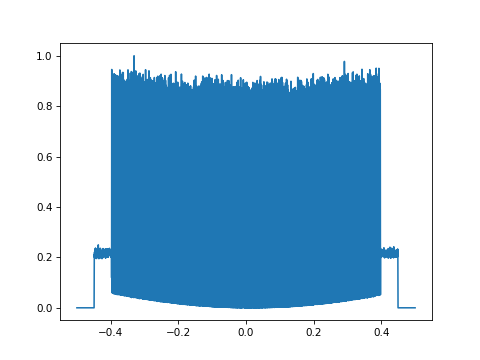

In [45]:
num_px_det_y = 5000
num_px_det_x = 1
det_image = np.zeros((num_px_det_y, num_px_det_x), dtype = np.complex128)

det_shape = [num_px_det_y, num_px_det_x]
det_width_y = 1
det_centre_y = 0.0

det_pixels_y, px_size_y = np.linspace(det_centre_y - det_width_y / 2, det_centre_y + det_width_y / 2, num_px_det_y, retstep = True)

pixel_coords_x, pixel_coords_y = get_pixel_coords(np.zeros(ry_end.shape), ry_end, det_shape, px_size_y)
pixel_coords_y, pixel_coords_x = np.round((pixel_coords_y, pixel_coords_x)).astype(int)

dx = np.sqrt((ry_end - det_pixels_y[pixel_coords_y]) ** 2)

ray_phase = np.exp(1j * (2*np.pi / wl) * (opl7 + dx * M3))
sy, sx = det_shape

mask = np.logical_and(
    np.logical_and(
        0 <= pixel_coords_y,
        pixel_coords_y < sy
    ),
    np.logical_and(
        0 <= pixel_coords_x,
        pixel_coords_x < sx
    )
)

flat_icds = np.ravel_multi_index(
    [
        pixel_coords_y[mask],
        pixel_coords_x[mask],
    ],
    det_shape
)

np.add.at(
    det_image.ravel(),
    flat_icds,
    ray_phase,
)

plt.figure()
plt.plot(det_pixels_y, np.abs(det_image[:, 0]) ** 2 / np.max(np.abs(det_image[:, 0]) ** 2))
# plt.plot(det_pixels_y, 1/2 * (np.cos(4 * np.pi * 200 * det_pixels_y / 0.2) + 1))
